ADF Test p-value: 0.6731196248236193
Data is non-stationary. Consider differencing.
ARIMA MAE: 10.660360014419057
ARIMA MAPE: 0.035952837691693
ETS MAE: 123.00795305969311
ETS MAPE: 0.41204480963788503


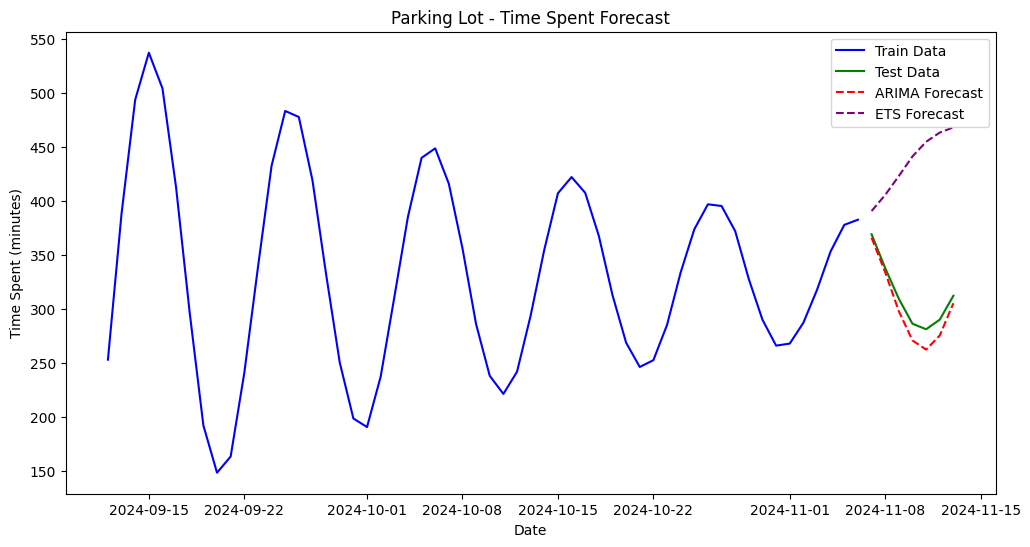

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv("D:\gitfolder\Data-DaVinci\Week 4\Assignment\FILES\parkingLot.csv")
data['timestamp'] = pd.to_datetime(data['timestamp']) - pd.Timedelta(seconds=1)  # Fix 12 o'clock issue
data['date'] = data['timestamp'].dt.date

# Grouping data
data_grouped = data.groupby(['vehicle_no', 'date'])
spent = []
for (vehicle_no, date), vehicle_data in data_grouped:
    if len(vehicle_data) % 2 == 0:
        for i in range(0, len(vehicle_data) - 1, 2):
            diff = vehicle_data['timestamp'].iloc[i + 1] - vehicle_data['timestamp'].iloc[i]
            spent.append({'date': date, 'time': diff.total_seconds() / 60})

df = pd.DataFrame(spent)
df = df.groupby('date').mean()

# Splitting dataset
df_train, df_test = df.iloc[:-7], df.iloc[-7:]

# Check stationarity
p_value = adfuller(df_train['time'])[1]
print("ADF Test p-value:", p_value)
if p_value > 0.05:
    print("Data is non-stationary. Consider differencing.")
else:
    print("Data is stationary.")

# ARIMA Model
model_arima = ARIMA(df_train['time'], order=(3, 1, 0))
model_fit_arima = model_arima.fit()
forecast_arima = model_fit_arima.forecast(steps=len(df_test))

# Evaluate ARIMA
mae_arima = mean_absolute_error(df_test['time'], forecast_arima)
mape_arima = mean_absolute_percentage_error(df_test['time'], forecast_arima)
print("ARIMA MAE:", mae_arima)
print("ARIMA MAPE:", mape_arima)

# ETS Model
model_ets = ETSModel(df_train['time'], error="add", trend="add", seasonal="add", seasonal_periods=7)
model_fit_ets = model_ets.fit()
forecast_ets = model_fit_ets.forecast(steps=len(df_test))

# Evaluate ETS
mae_ets = mean_absolute_error(df_test['time'], forecast_ets)
mape_ets = mean_absolute_percentage_error(df_test['time'], forecast_ets)
print("ETS MAE:", mae_ets)
print("ETS MAPE:", mape_ets)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['time'], label='Train Data', color='blue')
plt.plot(df_test.index, df_test['time'], label='Test Data', color='green')
plt.plot(df_test.index, forecast_arima, label='ARIMA Forecast', color='red', linestyle='dashed')
plt.plot(df_test.index, forecast_ets, label='ETS Forecast', color='purple', linestyle='dashed')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Time Spent (minutes)")
plt.title("Parking Lot - Time Spent Forecast")
plt.show()
